Nama : Suwandi Ramadhan
# ==============================================================================
#                      PROJECT 3 : VOICE RECOGNITION
#               Klasifikasi Maksud Ucapan (Intent Classification)
# ==============================================================================

#### TUJUAN :
Project ini bertujuan untuk membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
Kita akan menggunakan dataset MINDS-14 dari PolyAI, yang berisi rekaman suara
pelanggan bank dalam berbagai bahasa dengan label maksud yang jelas. <br>
https://huggingface.co/datasets/PolyAI/minds14

#### MODEL :
Kita akan melakukan fine-tuning pada model pre-trained Wav2Vec2, sebuah
arsitektur transformer yang sangat kuat untuk pemrosesan audio.

In [1]:
!pip install datasets transformers>=4.30.0 torch torchaudio soundfile evaluate jiwer -q

In [2]:
import os
import random
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from datasets import load_dataset, Audio
import matplotlib.pyplot as plt
from librosa.feature import mfcc as lb_mfcc

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 3: Load dataset and audio preprocessing settings
LANG = 'en-US'
SAMPLE_RATE = 16000
N_MFCC = 13
MAX_LEN = 500  # maximum timesteps for padding MFCC sequences

dataset = load_dataset("PolyAI/minds14", LANG)
# If no validation or test split, create a train/test split
dataset_splits = list(dataset.keys())
if 'validation' not in dataset_splits and 'test' not in dataset_splits:
    split_ds = dataset['train'].train_test_split(test_size=0.1, seed=42)
    dataset = split_ds
# Cast audio column to 16kHz
dataset = dataset.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

In [11]:
# Cell 4: Identify transcript column and build character-level one-hot encoder
example0 = dataset['train'][0]
transcript_col = next(k for k,v in example0.items() if isinstance(v, str))
print(f"Using transcript column: {transcript_col}")
token_set = set()
for ex in dataset['train']:
    token_set.update(list(ex[transcript_col].lower()))
chars = sorted(token_set)
ohe_params = {'handle_unknown':'ignore'}
try:
    ohe = OneHotEncoder(**ohe_params, sparse=False)
except TypeError:
    ohe = OneHotEncoder(**ohe_params, sparse_output=False)
ohe.fit(np.array(chars).reshape(-1,1))

Using transcript column: path


,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [15]:
# Cell 5: Custom Dataset
torch.manual_seed(42)
class SpeechDataset(Dataset):
    def __init__(self, split):
        self.data = dataset[split]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        path = ex['audio']['path'] if isinstance(ex['audio'], dict) else ex['audio']
        audio, _ = librosa.load(path, sr=SAMPLE_RATE)
        mfcc = lb_mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
        # Pad/truncate MFCC sequence
        if mfcc.shape[0] > MAX_LEN:
            mfcc = mfcc[:MAX_LEN]
        else:
            pad = np.zeros((MAX_LEN-mfcc.shape[0], N_MFCC))
            mfcc = np.vstack([mfcc, pad])
        # Encode transcript and pad/truncate to MAX_LEN
        transcript = ex[transcript_col].lower()
        chars_arr = np.array(list(transcript)).reshape(-1,1)
        y = ohe.transform(chars_arr)  # shape (L, V)
        # Pad or truncate y to length MAX_LEN
        if y.shape[0] > MAX_LEN:
            y = y[:MAX_LEN]
        else:
            pad_y = np.zeros((MAX_LEN - y.shape[0], y.shape[1]))
            y = np.vstack([y, pad_y])
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds = SpeechDataset('train')
eval_split = 'validation' if 'validation' in dataset else 'test'
eval_ds = SpeechDataset(eval_split)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True)
eval_loader = DataLoader(eval_ds, batch_size=8, drop_last=True)

In [16]:
# Cell 6: Define LSTM/GRU Model
type_rnn = 'gru'
hidden_size = 128
num_layers = 2
vocab_size = len(chars)

class SpeechModel(nn.Module):
    def __init__(self):
        super().__init__()
        rnn_cls = nn.GRU if type_rnn=='gru' else nn.LSTM
        self.rnn = rnn_cls(input_size=N_MFCC, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, vocab_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        logits = self.fc(out)
        return logits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SpeechModel().to(device)

In [17]:
# Cell 7: Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
train_losses, eval_losses = [], []
for epoch in range(1, num_epochs+1):
    model.train()
    total_train = 0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        B,T,V = logits.shape
        loss = criterion(logits.view(-1,V), torch.argmax(Y,dim=-1).view(-1))
        loss.backward()
        optimizer.step()
        total_train += loss.item()
    train_losses.append(total_train/len(train_loader))
    model.eval()
    total_eval = 0
    with torch.no_grad():
        for X, Y in eval_loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            B,T,V = logits.shape
            loss = criterion(logits.view(-1,V), torch.argmax(Y,dim=-1).view(-1))
            total_eval += loss.item()
    eval_losses.append(total_eval/len(eval_loader))
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Eval Loss: {eval_losses[-1]:.4f}")

Epoch 1/10 | Train Loss: 1.6374 | Eval Loss: 1.2837
Epoch 2/10 | Train Loss: 1.2088 | Eval Loss: 1.1428
Epoch 3/10 | Train Loss: 1.1195 | Eval Loss: 1.0848
Epoch 4/10 | Train Loss: 1.0614 | Eval Loss: 1.0770
Epoch 5/10 | Train Loss: 1.0405 | Eval Loss: 1.0223
Epoch 6/10 | Train Loss: 1.0009 | Eval Loss: 1.0092
Epoch 7/10 | Train Loss: 0.9896 | Eval Loss: 0.9736
Epoch 8/10 | Train Loss: 0.9611 | Eval Loss: 0.9541
Epoch 9/10 | Train Loss: 0.9404 | Eval Loss: 0.9987
Epoch 10/10 | Train Loss: 0.9276 | Eval Loss: 0.9564


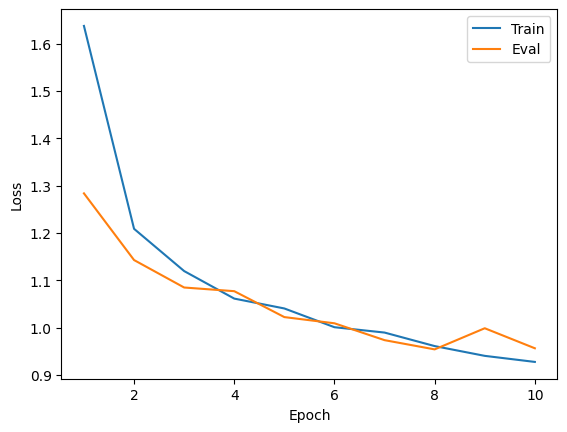

In [18]:
# Cell 8: Plot Loss Curves
plt.figure()
plt.plot(range(1,num_epochs+1), train_losses, label='Train')
plt.plot(range(1,num_epochs+1), eval_losses, label='Eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Cell 9: Inference Function
def inference(audio_path):
    audio,_ = librosa.load(audio_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
    mfcc = mfcc[:MAX_LEN] if mfcc.shape[0]>MAX_LEN else np.vstack([mfcc, np.zeros((MAX_LEN-mfcc.shape[0], N_MFCC))])
    X = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(X)
        pred_ids = torch.argmax(logits, dim=-1).cpu().numpy()[0]
    return ''.join([chars[i] for i in pred_ids])

In [20]:
# Cell 10: Example Inference
sample_path = train_ds.data[0]['audio']['path']
print("Prediksi sample:", inference(sample_path))


Prediksi sample: c:\\sssssssaaaaaaaaaaaaggggggggggggaaaaaaaaaaddoooooodddddddddddaaaaaaaaaaaaa1111111111111111166666666666333388888888888888888884eeeeeeeeeeeeeeeeeeeeeeeeeeeebbbbbbbb-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
